## EDA Notebook
- This notebook contains exploratory data analysis and vizualizations on the data
- The purpose is to have a better understanding of the dataset overall before diving into the math/numbers

## Main Sections
1. General Vizualizations and data aggregations
2. Outlier analysis using an **isolation forest** (at the bottom)

In [1]:
import pandas as pd  
import seaborn as sns

### Read in the data and check it's format for useability
- check the variable types 
- check for any missing data

In [2]:
shoe_orders_df = pd.read_csv('q1_data_set.csv')
shoe_orders_df.head()

order_id  shop_id  user_id  order_amount  total_items payment_method  \
0         1       53      746           224            2           cash   
1         2       92      925            90            1           cash   
2         3       44      861           144            1           cash   
3         4       18      935           156            1    credit_card   
4         5       18      883           156            1    credit_card   

            created_at  
0  2017-03-13 12:36:56  
1  2017-03-03 17:38:52  
2   2017-03-14 4:23:56  
3  2017-03-26 12:43:37  
4   2017-03-01 4:35:11

In [3]:
shoe_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


In [4]:
print('created_at dtype:', type(shoe_orders_df['created_at'][0]))
print('Different payment methods:', shoe_orders_df['payment_method'].unique())

created_at dtype: <class 'str'>
Different payment methods: ['cash' 'credit_card' 'debit']


- Order amount and items are numerical - no transformations needed here
- The date field is a string and should be converted for better use
- Payment methods can stay as string values, they are not needed as integers (no label encoding needed)

### Clean the data
- Before looking into anything, the data should be cleaned 
- Extract information from the created_at to have individual numerical features (easy to use later on)

In [5]:
def extract_time(df: pd.DataFrame, col_name: str = 'created_at', drop: bool = True) -> pd.DataFrame:
    """ Extract date/time data from the created_at column

    Args: 
        df: The current dataframe in use
        col_name: The column to extract time data from
        drop: If true, drop the original time column 

    Returns: 
        A new dataframe containing new column with separate information about date and time
    """
    df = df.copy()

    datetime_col = pd.to_datetime(df[col_name])
    # extract date info 
    df['day'] = datetime_col.dt.day
    df['month'] = datetime_col.dt.month
    df['year'] = datetime_col.dt.year
    df['weekday'] = datetime_col.dt.dayofweek
    df['year_day'] = datetime_col.dt.dayofyear

    # extract time info; ignore the seconds (different in seconds sholud not matter for orders)
    df['hours_time'] = datetime_col.dt.hour + (datetime_col.dt.minute / 60)

    if drop:
        df.drop(columns=[col_name], inplace=True)

    return df
orders_df = extract_time(shoe_orders_df)
orders_df.head()

order_id  shop_id  user_id  order_amount  total_items payment_method  day  \
0         1       53      746           224            2           cash   13   
1         2       92      925            90            1           cash    3   
2         3       44      861           144            1           cash   14   
3         4       18      935           156            1    credit_card   26   
4         5       18      883           156            1    credit_card    1   

   month  year  weekday  year_day  hours_time  
0      3  2017        0        72   12.600000  
1      3  2017        4        62   17.633333  
2      3  2017        1        73    4.383333  
3      3  2017        6        85   12.716667  
4      3  2017        2        60    4.583333

In [6]:
orders_df.shape

(5000, 12)

### Data Vizualization
- Perform some exploratory data analysis to get insight into the data distribution

Text(0, 0.5, 'Order Price')

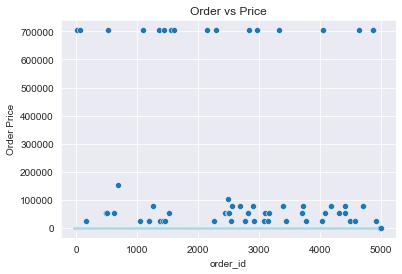

In [8]:
%matplotlib inline
sns.set_style('darkgrid')
# graph each order against order_amount to see how order order amount is distirbuted
price_by_order = sns.scatterplot(x='order_id', y='order_amount', data=orders_df)
price_by_order.set_title('Order vs Price')
price_by_order.set_ylabel('Order Price')

- From this first scatter plot, outliers are evident
- There are a few orders at \$700,000, and quite a few that seem to be between \$20,000 - \$100,000

### Group data by specific columns 
- Since there are many unique orders, examine the order amount by shop id, user id and total items 
- When calculating the mean in each of these 3 columns, factors affecting the AOV will start to become apparent

In [9]:
avg_cost_by_shop = orders_df.groupby('shop_id')['order_amount'].mean().sort_values(ascending=False)
avg_cost_by_user = orders_df.groupby('user_id')['order_amount'].mean().sort_values(ascending=False)
avg_cost_by_quantity = orders_df.groupby('total_items')['order_amount'].mean().sort_values(ascending=False)

### Shop Aggregation 

In [20]:
avg_cost_by_shop.head()

shop_id
42    235101.490196
78     49213.043478
50       403.545455
90       403.224490
38       390.857143
Name: order_amount, dtype: float64

### Shop Aggregation: Findings
- 2 shops have much higher mean order costs than the rest

### User Aggregation

In [21]:
avg_cost_by_user.head()

user_id
607    704000.000000
878     14266.909091
766      8007.600000
834      6019.000000
915      5785.142857
Name: order_amount, dtype: float64

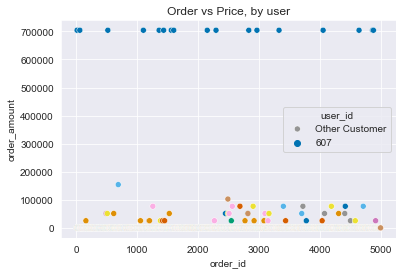

In [10]:
# same graph as the first one except with user_id as the hue
price_by_order = sns.scatterplot(x='order_id', y='order_amount', data=orders_df, hue='user_id', palette='colorblind')
price_by_order.set_title('Order vs Price, by user')
price_by_order.legend(['Other Customer', '607'], title='user_id')

### User Aggregation: Findings
- One specific user (607) has a mean order value of $704,000 which is much higher than the rest

### Quantity Aggregation

In [23]:
avg_cost_by_quantity.head()

total_items
2000    704000.000000
6        17940.000000
3         1191.076514
8         1064.000000
4          947.686007
Name: order_amount, dtype: float64

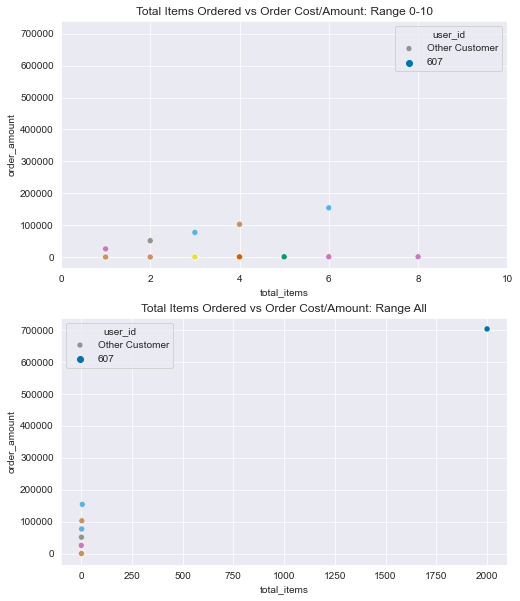

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, figsize=(8, 10))

quantity_v_amount_ax = sns.scatterplot(x='total_items', y='order_amount', hue='user_id', data=orders_df, ax=ax[0], palette='colorblind')
quantity_v_amount_ax.set_title('Total Items Ordered vs Order Cost/Amount: Range 0-10')
quantity_v_amount_ax.set_xlim(0, 10)
quantity_v_amount_ax.legend(['Other Customer', '607'], title='user_id')

quantity_v_amount_ax_2 = sns.scatterplot(x='total_items', y='order_amount', hue='user_id', data=orders_df, ax=ax[1], palette='colorblind')
quantity_v_amount_ax_2.set_title('Total Items Ordered vs Order Cost/Amount: Range All')
quantity_v_amount_ax_2.legend(['Other Customer', '607'], title='user_id')

 ### Quantity Aggregation: Findings
- This same customer (607) that had a mean order value of $704,000 also ordered 2000 shoes on average 
- Other than the one customer who has 2000 items per order, all other orders fall in the 1-8 item range per order
- The previous analysis has not revelaed any insight into price per shoe (at a certain store), so I will look into this next

### Explore the effects of store cost per shoe
- Since each store sells one shoe, look at costs by shop for one shoe
- Create a new feature called price per shoe and examine it's interaction with order cost


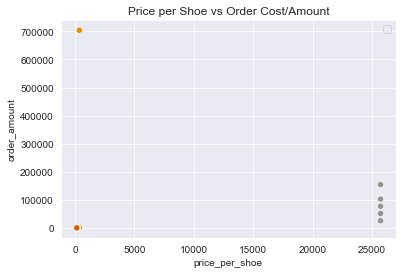

In [14]:
orders_df['price_per_shoe'] = orders_df['order_amount'] / orders_df['total_items']

per_shoe_ax = sns.scatterplot(x='price_per_shoe', y='order_amount', hue='shop_id', data=orders_df, palette='colorblind')
per_shoe_ax.set_title('Price per Shoe vs Order Cost/Amount')
per_shoe_ax.legend([])

### Explore the effects of store cost per shoe: Findings
- One shop sells very expensive shoes, at a cost of over $25,000 per shoe while all of the other shops have a selling point for shoes that is far lower

### Examine any time data 
- Since all the orders are made over a 30 day period, see if there is anything strange with amount of orders on certain days or time of day

Text(0.5, 0, 'Day of Year')

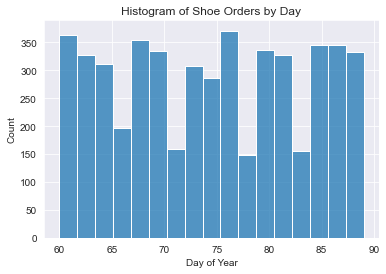

In [15]:
# we only have data made from 2017, see the amount of orders by month
orders_by_day = sns.histplot(x='year_day', data=orders_df)
orders_by_day.set_title('Histogram of Shoe Orders by Day')
orders_by_day.set_xlabel('Day of Year')

Text(0.5, 1.0, 'Histogram of Shoe Orders by Time')

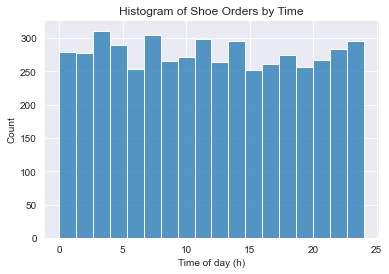

In [16]:
orders_by_hour = sns.histplot(x='hours_time', data=orders_df)
orders_by_hour.set_xlabel('Time of day (h)')
orders_by_hour.set_title('Histogram of Shoe Orders by Time')

### Examine any time data: Findings
- After drawing histograms for days and times of orders, there seems to be nothing for date or time that points to outliers in the data
- The final thing to examine would be payment methods since date/time do not seem relevant

### To get the outliers, I can train an isolation forest on the order amount
- Certain shops and users have higher average order values 
- From the first scatter plot it seems like there are around 1% of samples that are outliers, train an isolation forest to identify these outliers

In [33]:
from sklearn.ensemble import IsolationForest

def make_isolation_forest(df: pd.DataFrame, n_estimators: int, contamination: float) -> pd.DataFrame:
    # create an isolation forest model
    detector = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=8)
    detector.fit(df[['order_amount']])
    # use the fitted isolation forest and add it to the df to see the outliers
    outlier_df = df.copy()
    outlier_df['outlier'] = detector.predict(outlier_df[['order_amount']])
    outlier_df['score'] = detector.decision_function(outlier_df[['order_amount']])

    return outlier_df

# add the new columns from the isolation forest to a df - isolation forest that trains 50 trees with a contamination of 1%
outlier_df = make_isolation_forest(orders_df, 50, 0.01)

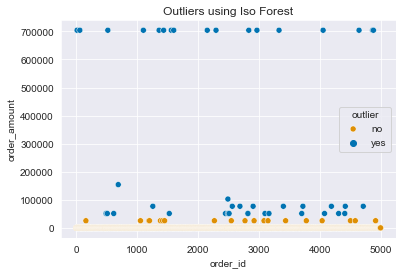

In [34]:
outlier_ax = sns.scatterplot(x='order_id', y='order_amount', hue='outlier', data=outlier_df, palette='colorblind')
outlier_ax.set_title('Outliers using Iso Forest')
outlier_ax.legend(['no', 'yes'], title='outlier')

### Isolation Forest Scatter Plot: Findings
- After training an isolation forest with 1% contamination, it is evident that the majority of the outliers have been detected
- To examine the outliers, I can locate the outliers in the data and sort by order amount, price per shoe, and order quantity 

In [36]:
only_outlier_df = outlier_df.loc[outlier_df['outlier'] == -1]
only_outlier_df.sort_values(by='order_amount', ascending=False).head()

order_id  shop_id  user_id  order_amount  total_items payment_method  \
15          16       42      607        704000         2000    credit_card   
1562      1563       42      607        704000         2000    credit_card   
4868      4869       42      607        704000         2000    credit_card   
4646      4647       42      607        704000         2000    credit_card   
4056      4057       42      607        704000         2000    credit_card   

      day  month  year  weekday  year_day  hours_time  price_per_shoe  \
15      7      3  2017        1        66         4.0           352.0   
1562   19      3  2017        6        78         4.0           352.0   
4868   22      3  2017        2        81         4.0           352.0   
4646    2      3  2017        3        61         4.0           352.0   
4056   28      3  2017        1        87         4.0           352.0   

      outlier     score  
15         -1 -0.089228  
1562       -1 -0.089228  
4868       -1 -0.089228  
4646       -1 -0.089228  
4056       -1 -0.089228

### Outlier Order Cost/Amount Sorting: Findings (Above)
- The most expensive order amounts come from user 607 with order amounts of \$704,000
- These orders were also all placed to the same shop, with shop id of 42

In [38]:
only_outlier_df.sort_values(by='total_items', ascending=False).head()

order_id  shop_id  user_id  order_amount  total_items payment_method  \
15          16       42      607        704000         2000    credit_card   
1562      1563       42      607        704000         2000    credit_card   
4868      4869       42      607        704000         2000    credit_card   
4646      4647       42      607        704000         2000    credit_card   
4056      4057       42      607        704000         2000    credit_card   

      day  month  year  weekday  year_day  hours_time  price_per_shoe  \
15      7      3  2017        1        66         4.0           352.0   
1562   19      3  2017        6        78         4.0           352.0   
4868   22      3  2017        2        81         4.0           352.0   
4646    2      3  2017        3        61         4.0           352.0   
4056   28      3  2017        1        87         4.0           352.0   

      outlier     score  
15         -1 -0.089228  
1562       -1 -0.089228  
4868       -1 -0.089228  
4646       -1 -0.089228  
4056       -1 -0.089228

### Outlier Order Quantity/Total Items Sorting: Findings (Above)
- The largest quantity of orders come from user 607 with order quantities of 2000 shoes

In [40]:
only_outlier_df.sort_values(by='price_per_shoe', ascending=False).head()

order_id  shop_id  user_id  order_amount  total_items payment_method  \
2690      2691       78      962         77175            3          debit   
3403      3404       78      928         77175            3          debit   
3101      3102       78      855         51450            2    credit_card   
3705      3706       78      828         51450            2    credit_card   
2906      2907       78      817         77175            3          debit   

      day  month  year  weekday  year_day  hours_time  price_per_shoe  \
2690   22      3  2017        2        81    7.550000         25725.0   
3403   16      3  2017        3        75    9.750000         25725.0   
3101   21      3  2017        1        80    5.166667         25725.0   
3705   14      3  2017        1        73   20.716667         25725.0   
2906   16      3  2017        3        75    3.750000         25725.0   

      outlier     score  
2690       -1 -0.038724  
3403       -1 -0.038724  
3101       -1 -0.024662  
3705       -1 -0.024662  
2906       -1 -0.038724

## Outlier Price Per Shoe Sorting: Findings (Above)
- The highest price per shoe was \$25,725/shoe 
- The shop with shop id 78 sold these expensive shoes
- These purchaes were all made by different customers
- The order quantities (total items) were different between the orders